### Generation des images des chiffres de 1 a 31

In [ ]:
import os
import csv
import random
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageOps


font = ImageFont.truetype("arial.ttf", 36)  #
output_dir = "dataset_chiffres_1_31_final"
os.makedirs(output_dir, exist_ok=True)
labels_file = os.path.join(output_dir, "labels.csv")

# === GÉNÉRATION DES IMAGES + LABELS ===
with open(labels_file, mode="w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "label"])  

    for label in range(1, 32):  
        for i in range(1500):
            img = Image.new("L", (64, 64), color=255) 
            draw = ImageDraw.Draw(img)
            text = str(label)

            # Position aléatoire dans l'image
            x_offset = random.randint(5, 15)
            y_offset = random.randint(5, 15)

            draw.text((x_offset, y_offset), text, font=font, fill=0)

            # Rotation aléatoire
            angle = random.randint(-20, 20)
            img = img.rotate(angle, fillcolor=255)

            # Flip aléatoire
            if random.random() < 0.3:
                img = ImageOps.mirror(img)
            if random.random() < 0.3:
                img = ImageOps.flip(img)

            # Luminosité aléatoire
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(0.8, 1.2))

            # Sauvegarde de l'image
            filename = f"{label}_{i}.png"
            filepath = os.path.join(output_dir, filename)
            img.save(filepath)

            # Sauvegarde du label dans le CSV
            writer.writerow([filename, label])

print(f"✅ Génération terminée : {31 * 1500} images dans '{output_dir}'")


✅ Génération terminée : 46500 images dans 'dataset_chiffres_1_31_final'


### Création du model de reconnaissance des chiffres de 1 à 31

In [2]:
import os
import csv
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split


class ChiffreCNN(nn.Module):
    def __init__(self):
        super(ChiffreCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 31)  # classes 1 à 31

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64 → 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 32x32 → 16x16
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Chargement des données
class ChiffreDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_path).convert('L')
        label = int(self.labels_df.iloc[idx, 1]) - 1  
        if self.transform:
            image = self.transform(image)
        return image, label
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChiffreCNN().to(device)

In [ ]:


img_dir = "dataset_chiffres_1_31_final"
csv_file = os.path.join(img_dir, "labels.csv")

# Split train/val
df = pd.read_csv(csv_file)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_csv = "train_labels.csv"
val_csv = "val_labels.csv"
train_df.to_csv(train_csv, index=False)
val_df.to_csv(val_csv, index=False)

# Transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = ChiffreDataset(train_csv, img_dir, transform)
val_dataset = ChiffreDataset(val_csv, img_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_val_acc = 0.0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total

    print(f"📘 Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_chiffre_cnn.pth")
        print("✅ Nouveau meilleur modèle sauvegardé")

print("🏁 Entraînement terminé.")


📘 Epoch 1/10 | Train Acc: 71.08% | Val Acc: 93.49%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 2/10 | Train Acc: 95.65% | Val Acc: 97.48%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 3/10 | Train Acc: 97.69% | Val Acc: 98.61%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 4/10 | Train Acc: 98.34% | Val Acc: 98.70%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 5/10 | Train Acc: 98.73% | Val Acc: 98.97%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 6/10 | Train Acc: 98.83% | Val Acc: 99.00%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 7/10 | Train Acc: 98.98% | Val Acc: 99.45%
✅ Nouveau meilleur modèle sauvegardé
📘 Epoch 8/10 | Train Acc: 99.14% | Val Acc: 99.16%
📘 Epoch 9/10 | Train Acc: 99.21% | Val Acc: 98.67%
📘 Epoch 10/10 | Train Acc: 99.30% | Val Acc: 99.56%
✅ Nouveau meilleur modèle sauvegardé
🏁 Entraînement terminé.


### Test pour predire les images manquants 

Traitement de l'image : image_roi_01.jpg


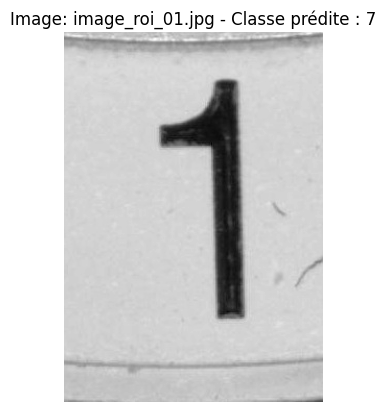

Traitement de l'image : image_roi_02.jpg


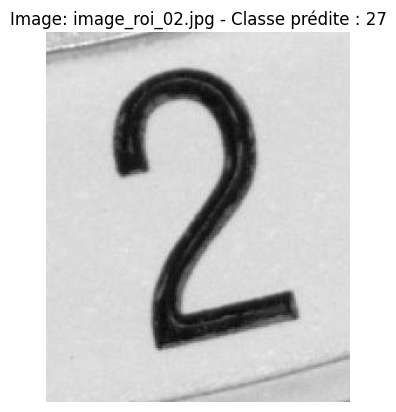

Traitement de l'image : image_roi_03.jpg


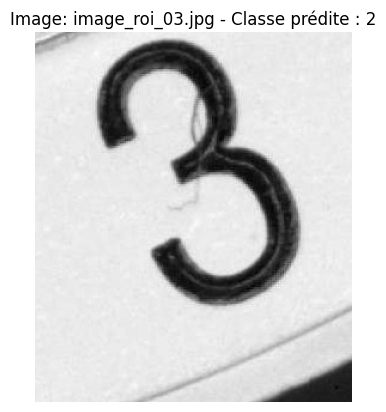

Traitement de l'image : image_roi_04.jpg


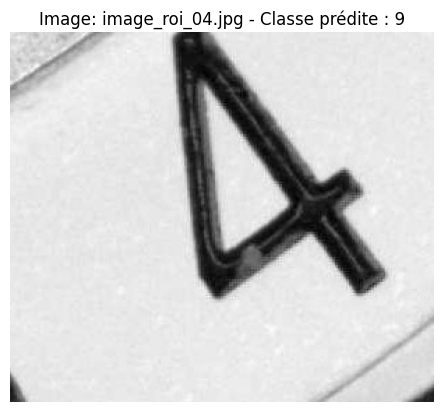

Traitement de l'image : image_roi_05.jpg


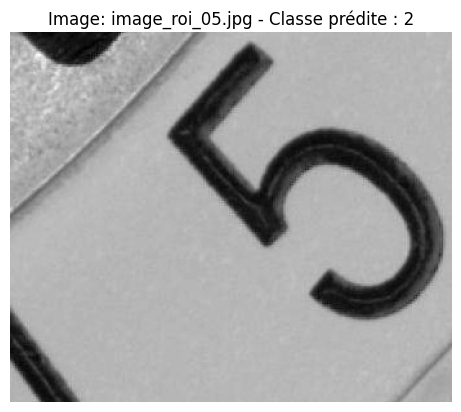

Traitement de l'image : image_roi_06.jpg


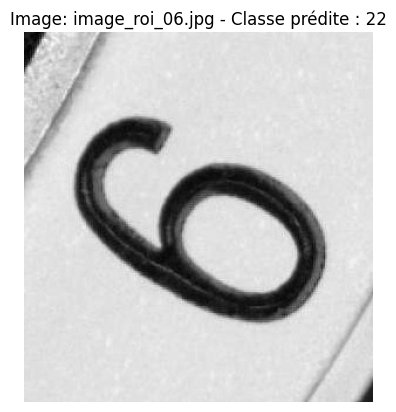

Traitement de l'image : image_roi_07.jpg


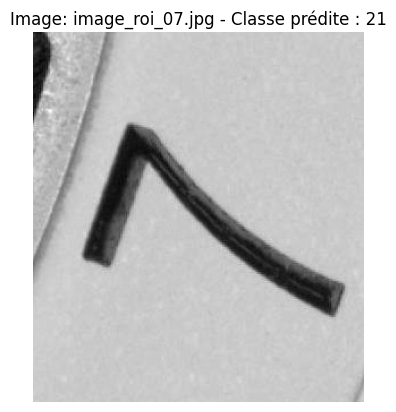

Traitement de l'image : image_roi_08.jpg


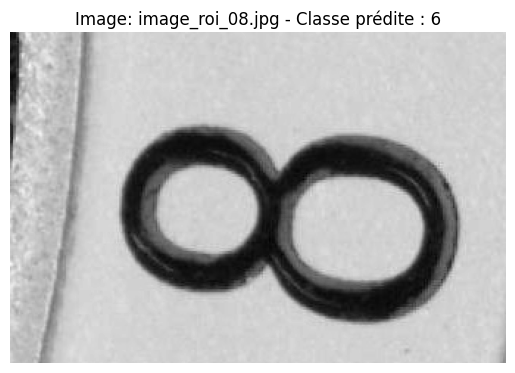

Traitement de l'image : image_roi_09.jpg


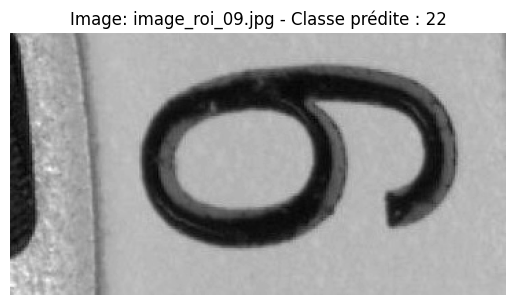

Traitement de l'image : image_roi_10.jpg


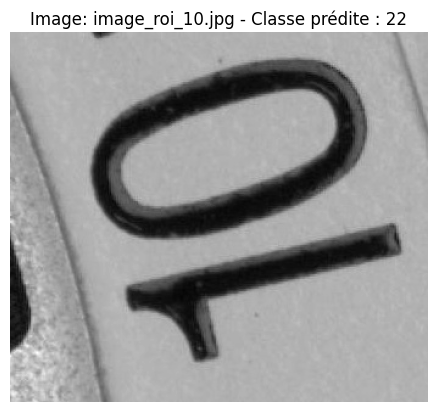

Traitement de l'image : image_roi_11.jpg


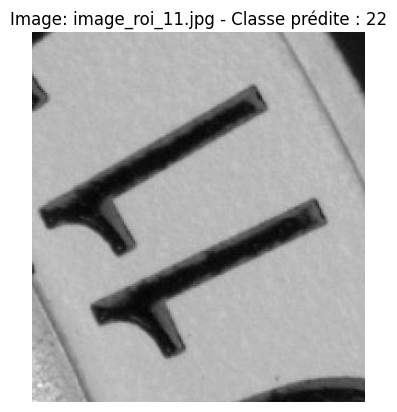

Traitement de l'image : image_roi_12.jpg


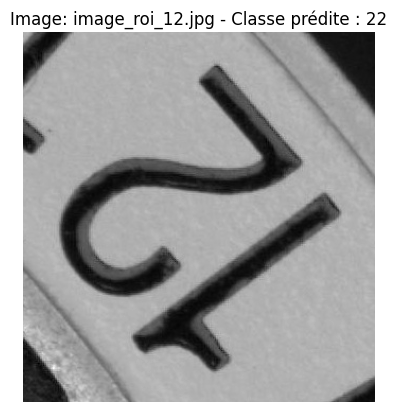

Traitement de l'image : image_roi_13.jpg


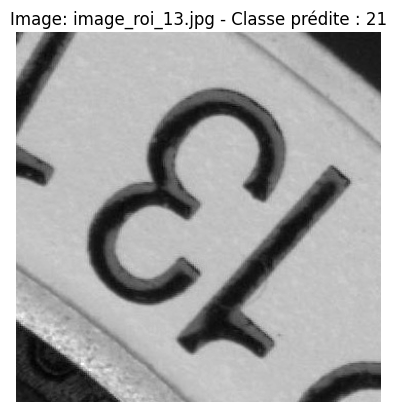

Traitement de l'image : image_roi_14.jpg


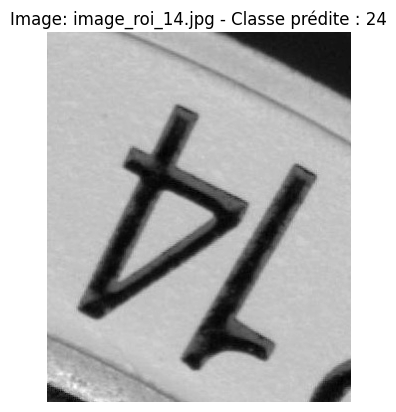

Traitement de l'image : image_roi_15.jpg


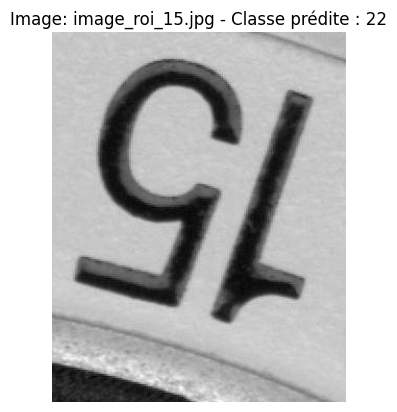

Traitement de l'image : image_roi_16.jpg


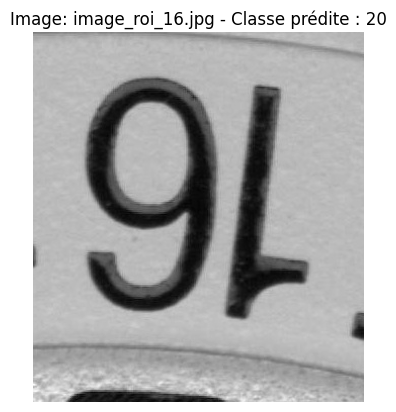

Traitement de l'image : image_roi_17.jpg


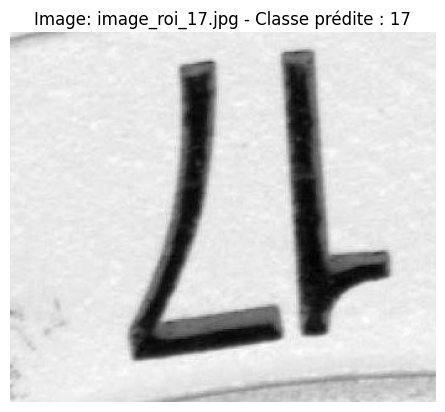

Traitement de l'image : image_roi_18.jpg


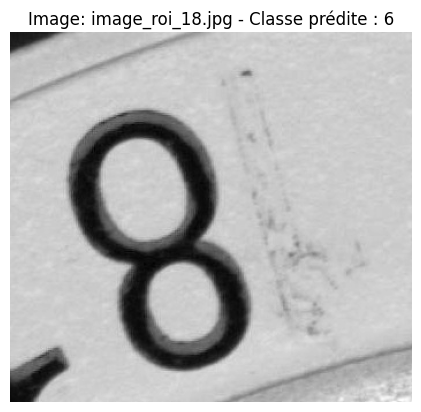

Traitement de l'image : image_roi_19.jpg


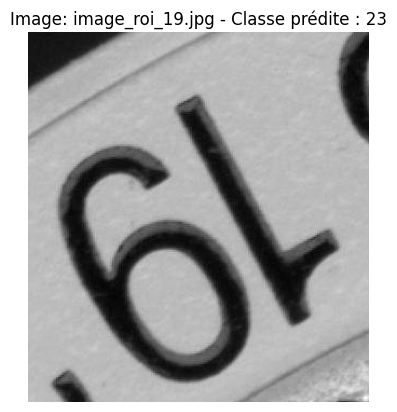

Traitement de l'image : image_roi_20.jpg


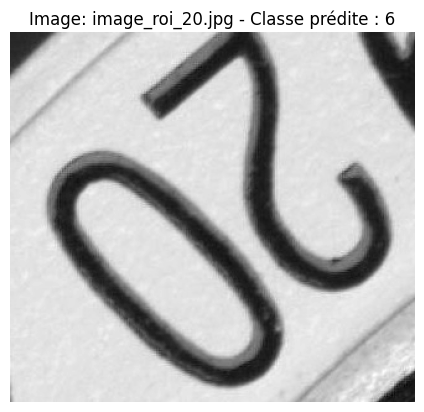

Traitement de l'image : image_roi_21.jpg


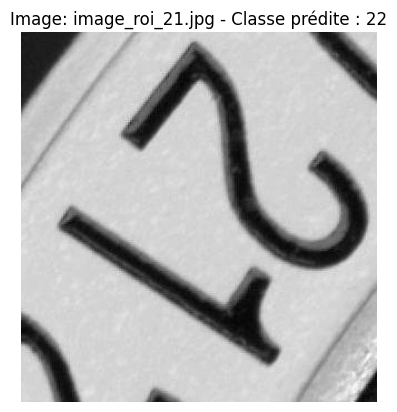

Traitement de l'image : image_roi_22.jpg


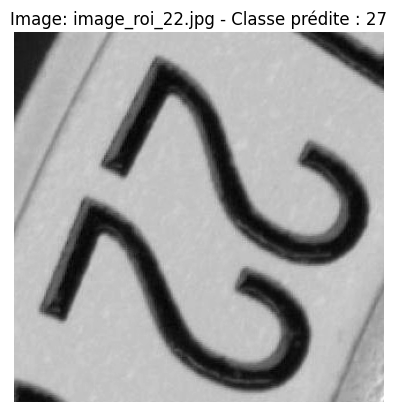

Traitement de l'image : image_roi_23.jpg


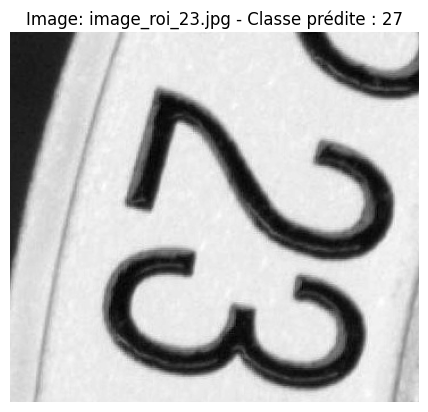

Traitement de l'image : image_roi_24.jpg


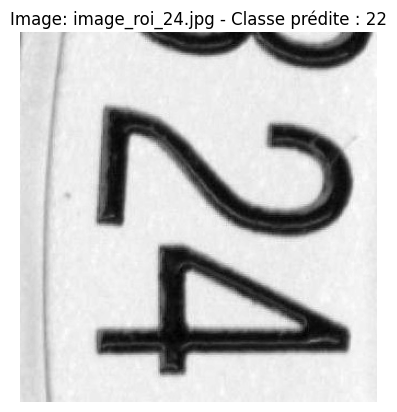

Traitement de l'image : image_roi_25.jpg


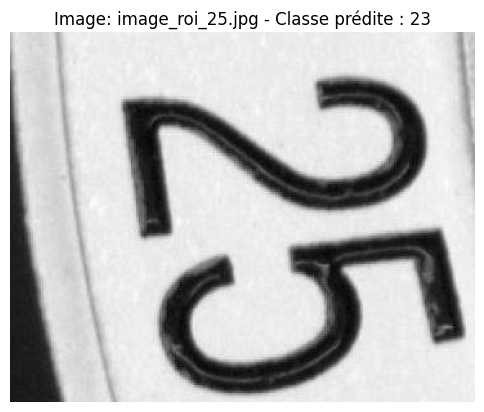

Traitement de l'image : image_roi_26.jpg


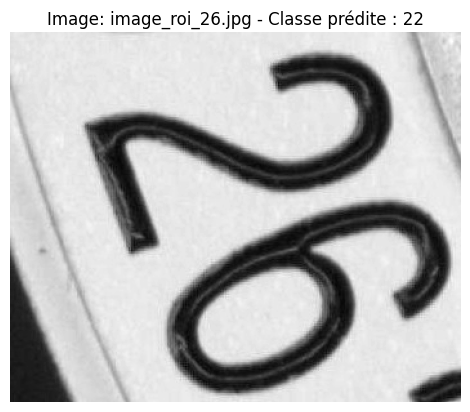

Traitement de l'image : image_roi_27.jpg


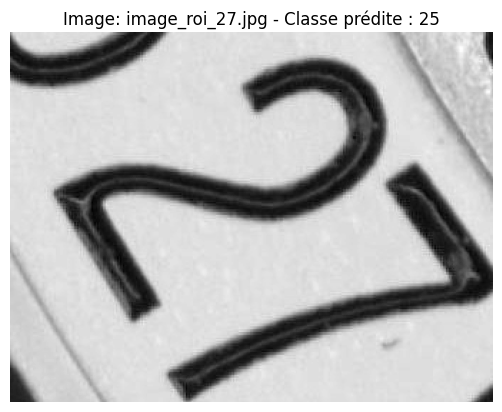

Traitement de l'image : image_roi_28.jpg


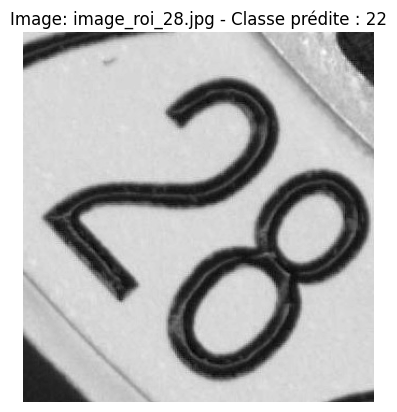

Traitement de l'image : image_roi_29.jpg


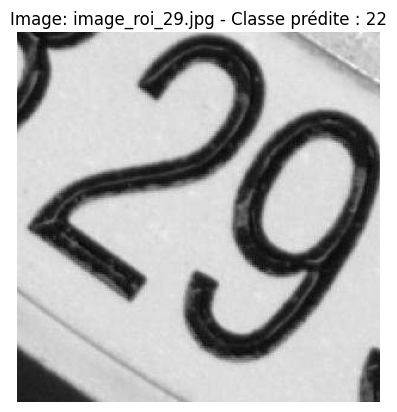

Traitement de l'image : image_roi_30.jpg


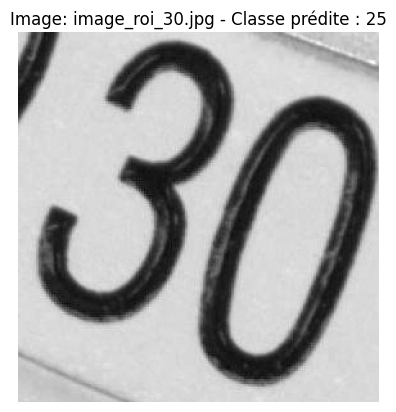

Traitement de l'image : image_roi_31.jpg


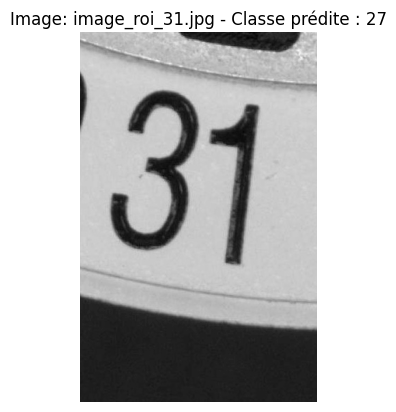

Traitement de l'image : roi_01_CONFORME.png


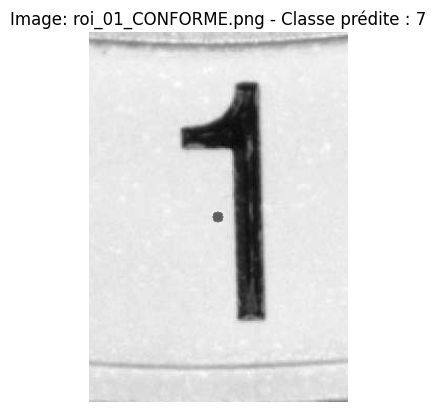

Traitement de l'image : roi_02_CONFORME.png


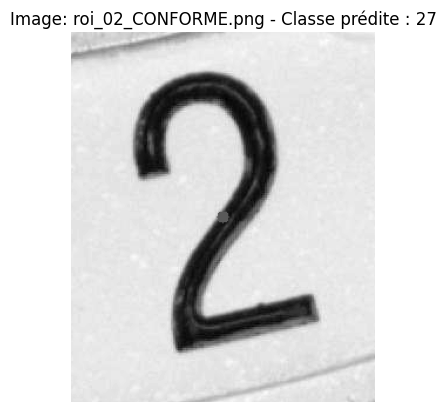

Traitement de l'image : roi_03_CONFORME.png


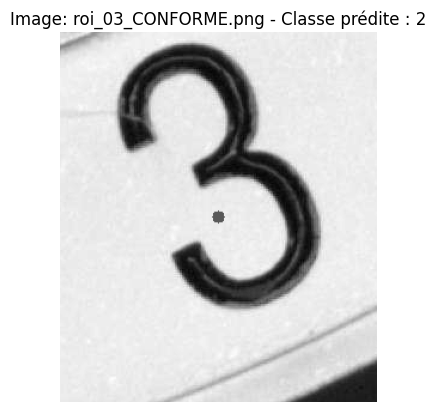

Traitement de l'image : roi_04_CONFORME.png


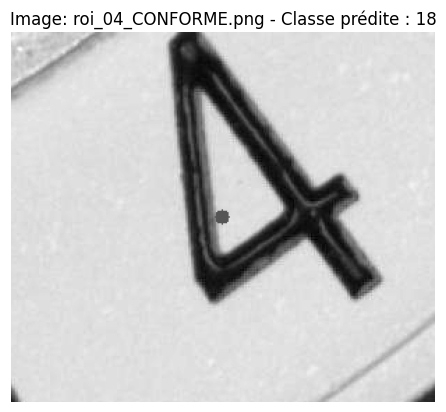

Traitement de l'image : roi_05_CONFORME.png


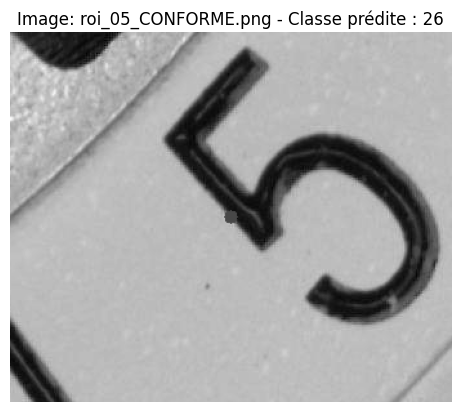

Traitement de l'image : roi_06_CONFORME.png


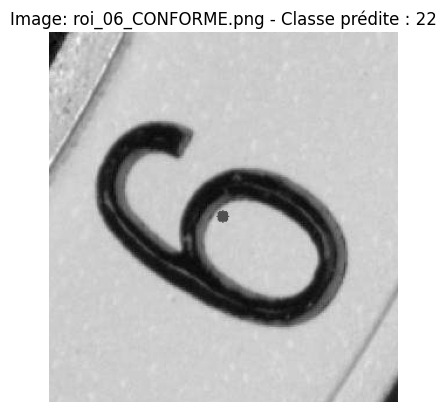

Traitement de l'image : roi_07_CONFORME.png


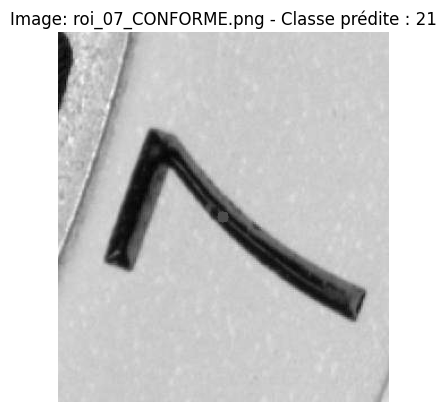

Traitement de l'image : roi_08_CONFORME.png


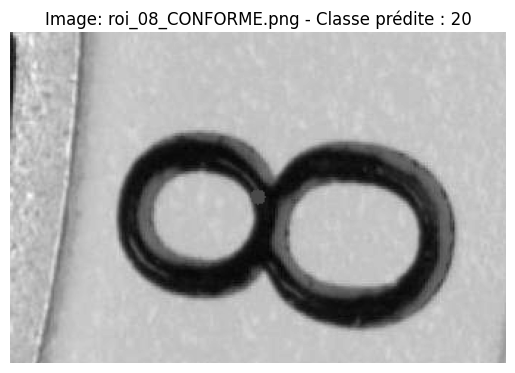

Traitement de l'image : roi_09_CONFORME.png


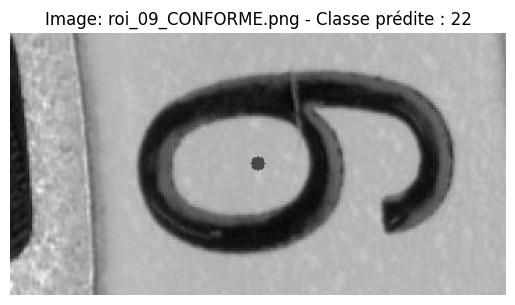

Traitement de l'image : roi_10_CONFORME.png


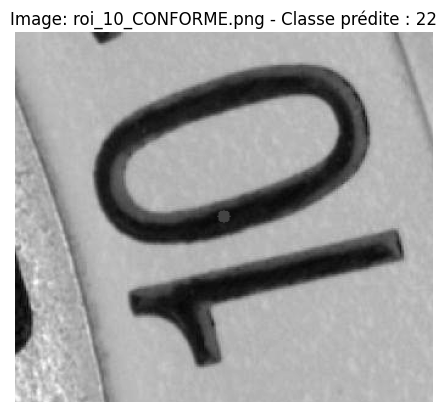

Traitement de l'image : roi_11_CONFORME.png


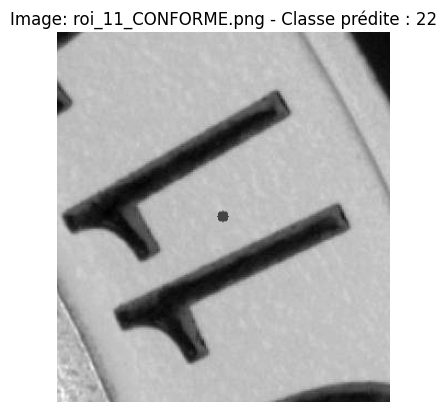

Traitement de l'image : roi_12_CONFORME.png


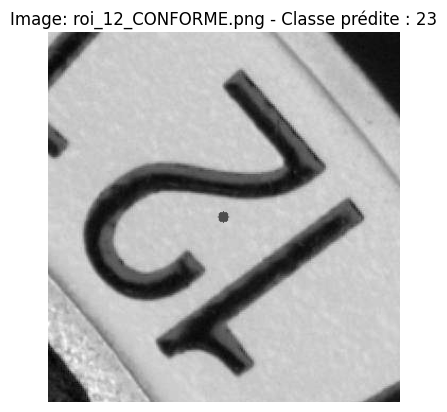

Traitement de l'image : roi_13_CONFORME.png


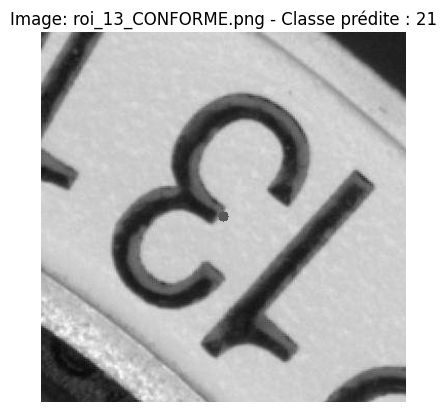

Traitement de l'image : roi_14_CONFORME.png


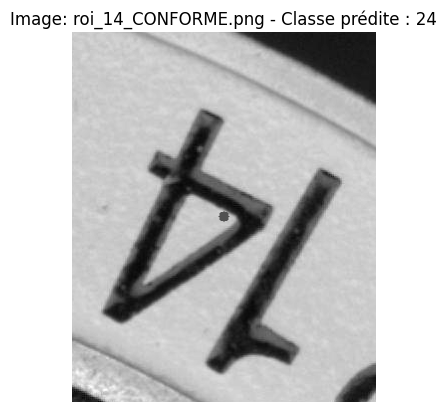

Traitement de l'image : roi_15_CONFORME.png


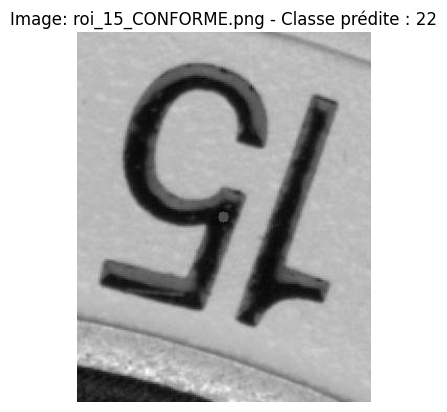

Traitement de l'image : roi_16_CONFORME.png


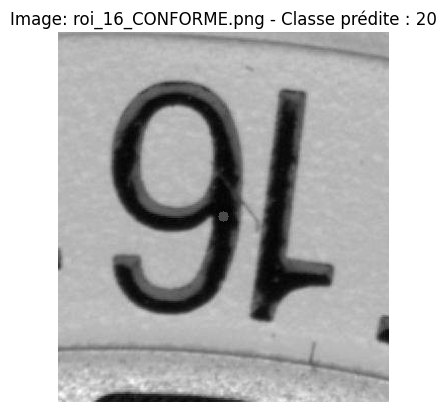

Traitement de l'image : roi_17_CONFORME.png


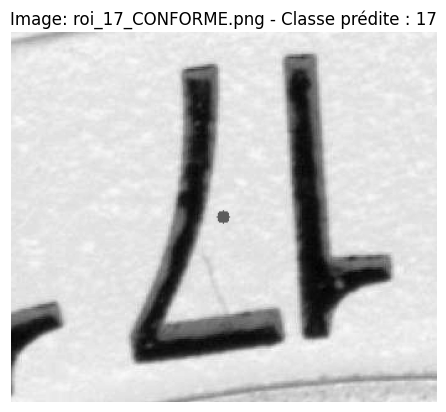

Traitement de l'image : roi_18_CONFORME.png


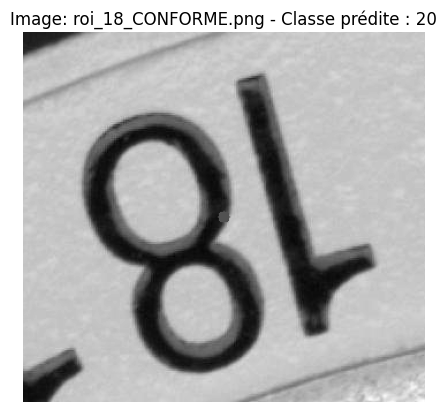

Traitement de l'image : roi_19_CONFORME.png


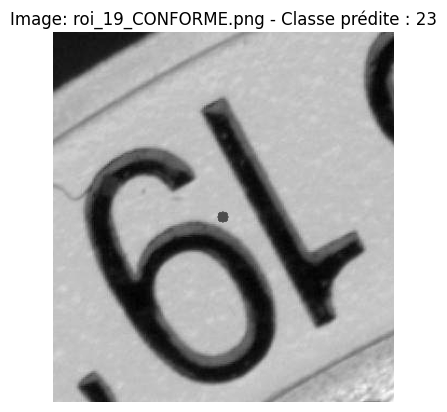

Traitement de l'image : roi_20_CONFORME.png


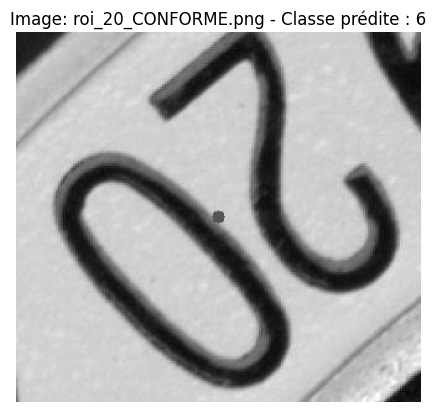

Traitement de l'image : roi_21_CONFORME.png


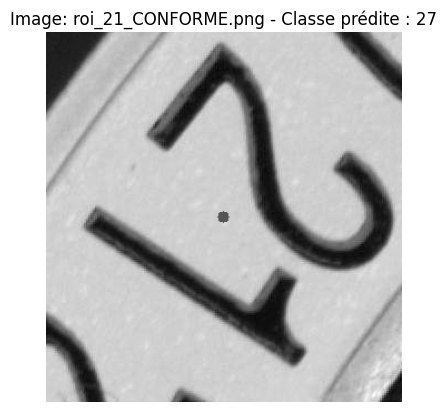

Traitement de l'image : roi_22_CONFORME.png


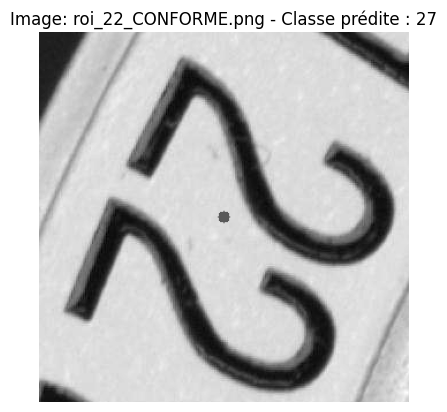

Traitement de l'image : roi_23_CONFORME.png


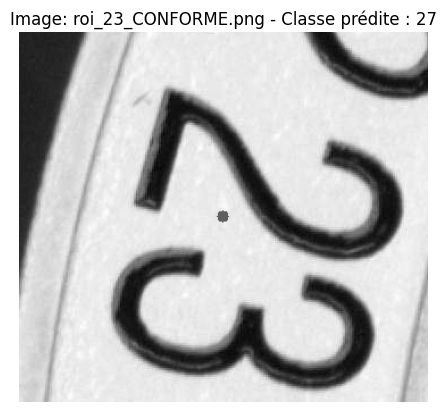

Traitement de l'image : roi_24_CONFORME.png


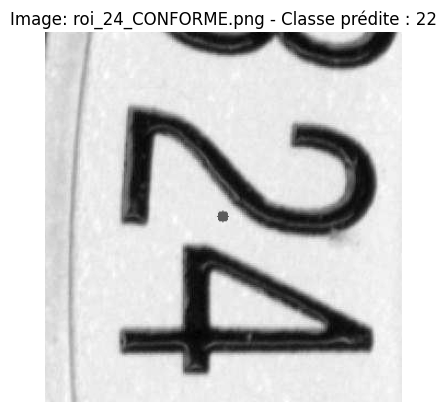

Traitement de l'image : roi_25_CONFORME.png


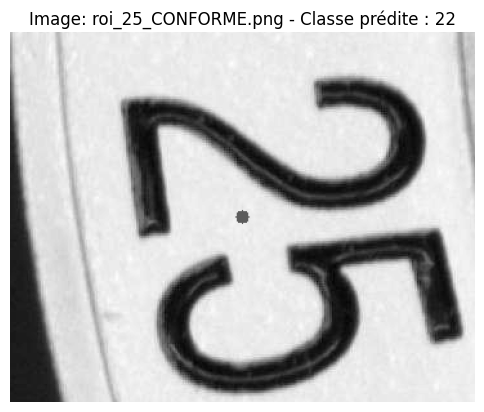

Traitement de l'image : roi_26_CONFORME.png


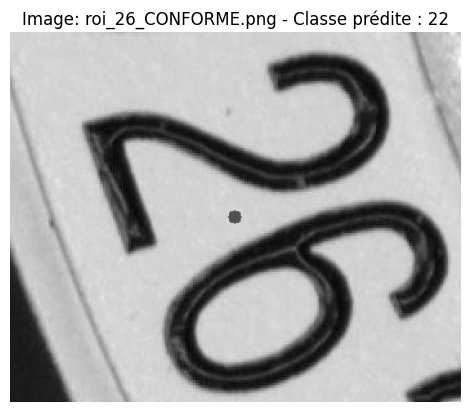

Traitement de l'image : roi_27_CONFORME.png


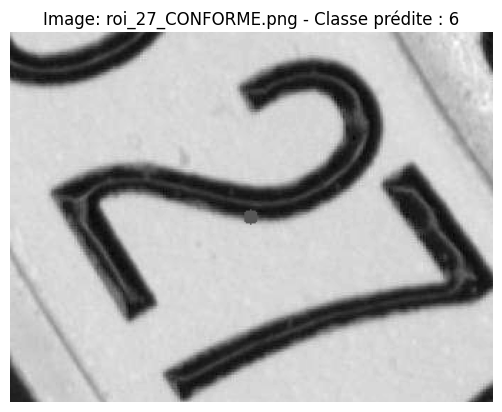

Traitement de l'image : roi_28_CONFORME.png


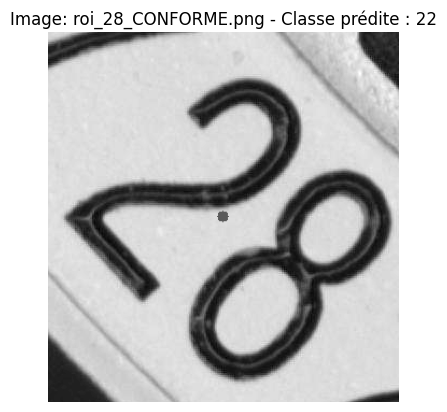

Traitement de l'image : roi_29_CONFORME.png


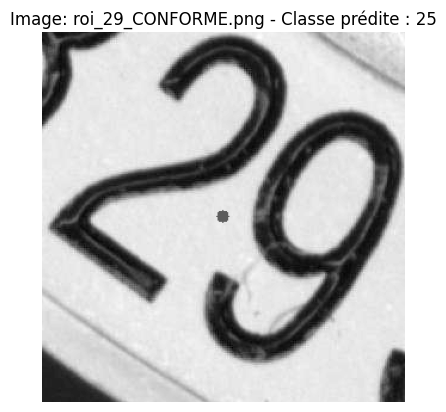

Traitement de l'image : roi_30_CONFORME.png


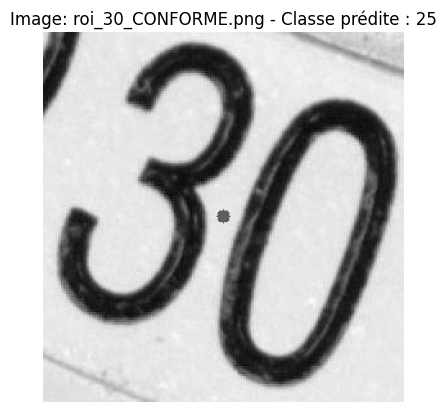

Traitement de l'image : roi_31_CONFORME.png


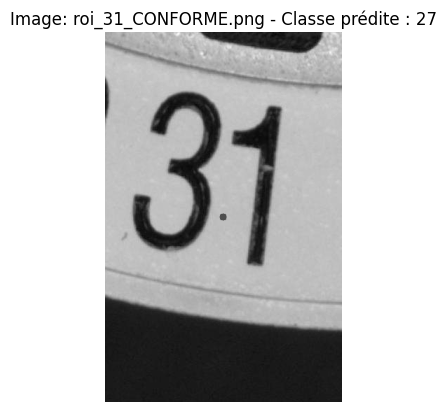


Résumé des prédictions :
Image: image_roi_01.jpg, Classe prédite: 7
Image: image_roi_02.jpg, Classe prédite: 27
Image: image_roi_03.jpg, Classe prédite: 2
Image: image_roi_04.jpg, Classe prédite: 9
Image: image_roi_05.jpg, Classe prédite: 2
Image: image_roi_06.jpg, Classe prédite: 22
Image: image_roi_07.jpg, Classe prédite: 21
Image: image_roi_08.jpg, Classe prédite: 6
Image: image_roi_09.jpg, Classe prédite: 22
Image: image_roi_10.jpg, Classe prédite: 22
Image: image_roi_11.jpg, Classe prédite: 22
Image: image_roi_12.jpg, Classe prédite: 22
Image: image_roi_13.jpg, Classe prédite: 21
Image: image_roi_14.jpg, Classe prédite: 24
Image: image_roi_15.jpg, Classe prédite: 22
Image: image_roi_16.jpg, Classe prédite: 20
Image: image_roi_17.jpg, Classe prédite: 17
Image: image_roi_18.jpg, Classe prédite: 6
Image: image_roi_19.jpg, Classe prédite: 23
Image: image_roi_20.jpg, Classe prédite: 6
Image: image_roi_21.jpg, Classe prédite: 22
Image: image_roi_22.jpg, Classe prédite: 27
Image: image_

In [3]:
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

def predict_image(image_path_or_pil, model, transform, device):
    if isinstance(image_path_or_pil, str):
        image = Image.open(image_path_or_pil).convert("L")
    else:
        image = image_path_or_pil.convert("L")
    
    input_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item() + 1  # Revenir à 1–31
    
    plt.imshow(image, cmap="gray")
    plt.title(f"Image: {os.path.basename(image_path_or_pil) if isinstance(image_path_or_pil, str) else 'PIL Image'} - Classe prédite : {predicted_label}")
    plt.axis("off")
    plt.show()
    
    return predicted_label

def predict_images_in_folder(folder_path, model, transform, device):
    # Liste pour stocker les résultats
    predictions = []
    
    # Vérifier si le dossier existe
    if not os.path.exists(folder_path):
        print(f"Erreur : Le dossier {folder_path} n'existe pas.")
        return predictions
    
    # Parcourir toutes les images dans le dossier
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  
            image_path = os.path.join(folder_path, filename)
            print(f"Traitement de l'image : {filename}")
            
            # Prédire la classe de l'image
            predicted_label = predict_image(image_path, model, transform, device)
            predictions.append((filename, predicted_label))
    
    
    print("\nRésumé des prédictions :")
    for filename, label in predictions:
        print(f"Image: {filename}, Classe prédite: {label}")
    
    return predictions


# Configuration 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Chargement du modèle enregistré
model = ChiffreCNN().to(device)
model.load_state_dict(torch.load("best_chiffre_cnn.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dossier contenant les images
folder_path = "extracted_rois"

# Prédire pour toutes les images dans le dossier
predictions = predict_images_in_folder(folder_path, model, transform, device)